In [1]:
import os
import time
import torch
import datetime
import itertools
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from tensorboardX import SummaryWriter
from torchsummary import summary

from sagan_models import Generator, Discriminator, Encoder
from spectral import SpectralNorm
from utils import *

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tester
from sagan_models import Generator, Encoder, Discriminator
from data_loader import Data_Loader
from utils import denorm

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
batch_size = 64
G = Generator(batch_size, 64, 128, 64).to(device)
E = Encoder(batch_size, 64, 128, 64).to(device)
D = Discriminator(batch_size, 128, 64).to(device)

In [5]:
ds = Data_Loader(train=False, dataset='mura', mura_class='XR_SHOULDER', mura_type='', 
                 image_path='/home/phuc/hdd/datasets', image_size=64, batch_size=64)
dl, ds = ds.loader()

Dataset lengh:  563


In [10]:
model_save_path = 'models/alpha_shoulder1/52800'
G.load_state_dict(torch.load(model_save_path + '_G.pth'))
E.load_state_dict(torch.load(model_save_path + '_E.pth'))
D.load_state_dict(torch.load(model_save_path + '_D.pth'))
print('loaded trained models (step: {})..!'.format(model_save_path))

RuntimeError: Error(s) in loading state_dict for Encoder:
	Missing key(s) in state_dict: "last.0.weight", "last.0.bias". 
	Unexpected key(s) in state_dict: "mean.0.weight", "mean.0.bias", "log_var.0.weight", "log_var.0.bias". 

In [10]:
data_iter = iter(dl)
with torch.no_grad(): 
    l1 = []
    l2 = []
    ld = []
    ld5 = []
    ld4 = []
    ld3 = []
    labels = []
    
    for i, data in enumerate(data_iter):
        val_images, val_labels = data
        val_images = tensor2var(val_images)
        labels.append(val_labels)

        # Run val images through models X -> E(X) -> G(E(X))
        mean_z, mean_logvar, ef1, ef2 = E(val_images)
        z = mean_z + mean_logvar * torch.randn(mean_z.size()).cuda()
        rec_images, gf1, gf2 = G(z)

        d_real, d_real4, d_real3 = D(val_images)
        d_rec, d_rec4, d_rec3 = D(rec_images)

        # Compute residual loss 
        l1.append((val_images - rec_images).abs().view(val_images.size(0), -1).mean(dim=-1))
        l2.append((val_images - rec_images).pow(2).sqrt().view(val_images.size(0), -1).mean(dim=-1))
        # Computer feature matching loss
        ld.append((d_real - d_rec).view((d_real.size(0), -1)).mean(dim=1))
        ld4.append((d_real4 - d_rec4).view((d_real4.size(0), -1)).mean(dim=1))
        ld3.append((d_real3 - d_rec3).view((d_real3.size(0), -1)).mean(dim=1))

    l1 = np.stack(torch.cat(l1).cpu().data)
    l2 = np.stack(torch.cat(l2).cpu().data)
    ld = np.stack(torch.cat(ld).cpu().data)
    ld4 = np.stack(torch.cat(ld4).cpu().data)
    ld3 = np.stack(torch.cat(ld3).cpu().data)
    labels = np.stack(torch.cat(labels).cpu().data)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


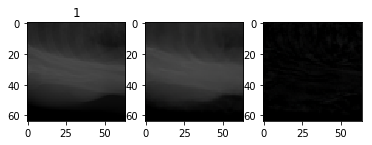

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


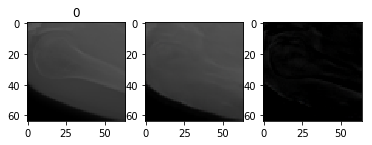

Press Enter to continue... 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


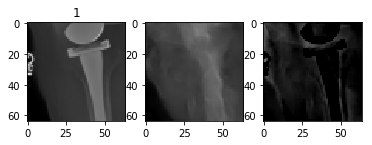

Press Enter to continue... 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


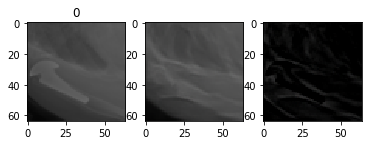

KeyboardInterrupt: 

In [11]:
for i in range(val_images.size(0)):
    plt.subplot(131)
    plt.imshow(denorm(val_images[i]).transpose(0,2))
    plt.title(labels[i])
    plt.subplot(132)
    plt.imshow(denorm(rec_images[i]).transpose(0,2))
    plt.subplot(133)
    plt.imshow(((rec_images[i]-val_images[i])).transpose(0,2))
    plt.show()
    input("Press Enter to continue...") 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


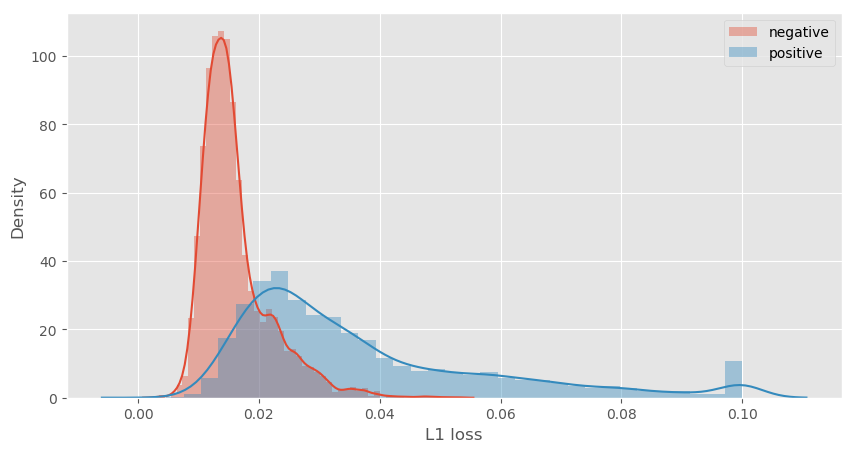

In [26]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
sns.distplot(l1[labels==0], hist=True, label='negative')
sns.distplot(l1[labels==1].clip(min=None, max=0.10), hist=True, label='positive')
plt.xlabel('L1 loss')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


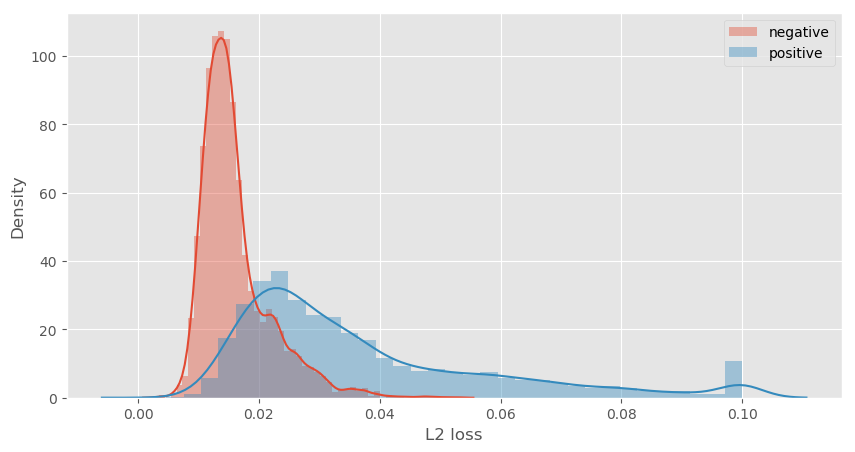

In [27]:
plt.figure(figsize=(10, 5))
sns.distplot(l2[labels==0], hist=True, label='negative')
sns.distplot(l2[labels==1].clip(min=None, max=0.10), hist=True, label='positive')
plt.xlabel('L2 loss')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


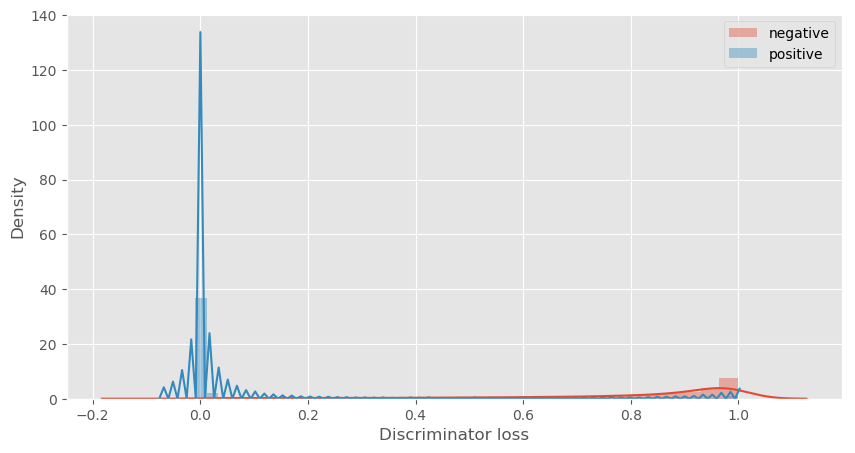

In [30]:
plt.figure(figsize=(10, 5))
sns.distplot(ld[labels==0], hist=True, label='negative')
sns.distplot(ld[labels==1], hist=True, label='positive')
plt.xlabel('Discriminator loss')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


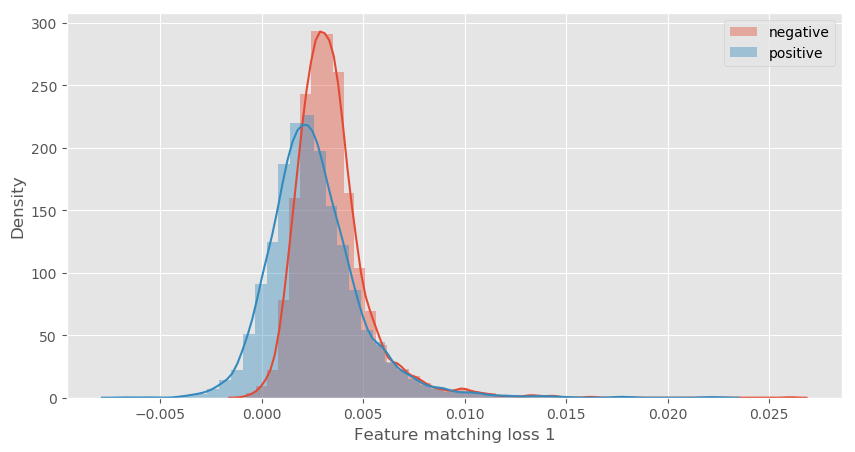

In [32]:
plt.figure(figsize=(10, 5))
sns.distplot(ld4[labels==0], hist=True, label='negative')
sns.distplot(ld4[labels==1], hist=True, label='positive')
plt.xlabel('Feature matching loss 1')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


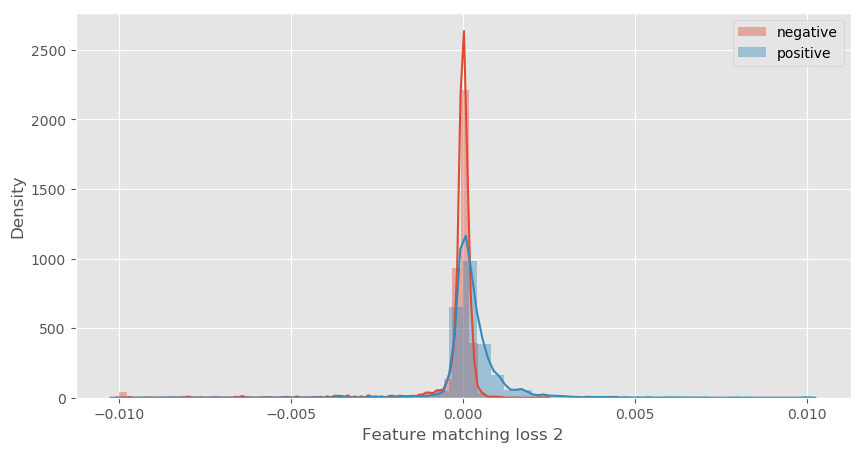

In [34]:
plt.figure(figsize=(10, 5))
sns.distplot(ld3[labels==0].clip(min=-0.01, max=0.01), hist=True, label='negative')
sns.distplot(ld3[labels==1].clip(min=-0.01, max=0.01), hist=True, label='positive')
plt.xlabel('Feature matching loss 2')
plt.ylabel('Density')
plt.legend()

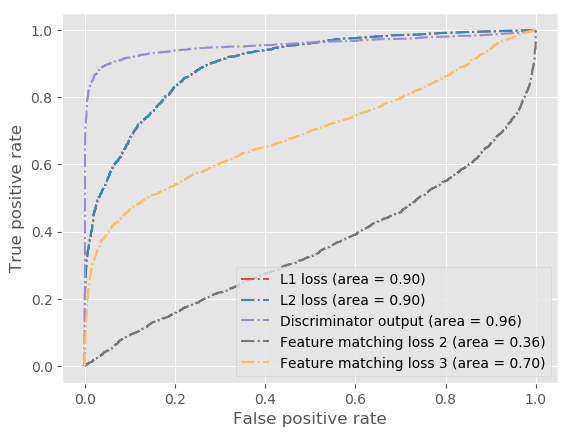

In [40]:
fpr, tpr, thresh = roc_curve(labels, l1)
auc = roc_auc_score(labels, l1)
plt.plot(fpr, tpr, '-.', label=f'L1 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, l2)
auc = roc_auc_score(labels, l2)
plt.plot(fpr, tpr, '-.', label=f'L2 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, -ld)
auc = roc_auc_score(labels, -ld)
plt.plot(fpr, tpr, '-.', label=f'Discriminator output (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, ld4)
auc = roc_auc_score(labels, ld4)
plt.plot(fpr, tpr, '-.', label=f'Feature matching loss 2 (area = {auc:.2f})')
                    
fpr, tpr, thresh = roc_curve(labels, ld3)
auc = roc_auc_score(labels, ld3)
plt.plot(fpr, tpr, '-.', label=f'Feature matching loss 3 (area = {auc:.2f})')
                    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()